In [1]:
import pysmt
from xbpy import rdutil
import numpy as np

In [2]:
from xbpy import possible_geometries, ideal_bond_lengths

In [3]:
#test_mol = next(rdutil.read_molecules("test_cases/Mureidomycin E PDB.pdb"))
test_mol = next(rdutil.read_molecules("test_cases/generic_substruct_match_test.pdb", proximityBonding=False))

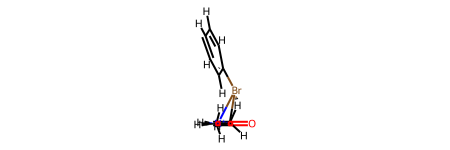

In [4]:
test_mol

In [5]:
from itertools import combinations
def get_pairswise_bond_angles(atom, position_array):
    pairwise_bond_angles = {}
    for neighbor1, neighbor2 in combinations([neighbor.GetIdx() for neighbor in atom.GetNeighbors()], 2):
        pairwise_bond_angles[(neighbor1, neighbor2)] = calculate_angle(position_array[neighbor1], position_array[atom.GetIdx()], position_array[neighbor2])
    return pairwise_bond_angles
def calculate_angle(v1, v2, v3):
    """
    Calculate the angle at v2 formed by v1-v2-v3 in degrees.
    """
    a = np.array(v1) - np.array(v2)
    b = np.array(v3) - np.array(v2)
    cosine_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    # Clamp the cosine_angle to the valid range to avoid numerical issues
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.degrees(np.arccos(cosine_angle))
    return angle

def get_all_pairwise_bond_angles(mol):
    positions = rdutil.positions(mol)
    pairwise_angles = {}
    for atom in mol.GetAtoms():
        center_atom_angles = {}
        for neighbor1, neighbor2 in combinations([neighbor.GetIdx() for neighbor in atom.GetNeighbors()], 2):
            angle = calculate_angle(positions[neighbor1], positions[atom.GetIdx()], positions[neighbor2])
            center_atom_angles[(neighbor1, neighbor2)] = angle
            center_atom_angles[(neighbor2, neighbor1)] = angle
        pairwise_angles[atom.GetIdx()] = center_atom_angles
    return pairwise_angles
    
def get_violating_atom_clusters(mol, all_pairwise_bond_angles, angle_tolerance = 10, add_hydrogens = False):
    positions = rdutil.positions(mol)

    violating_atoms = set()
    considerable_geometries = {}
    # id violating atoms
    for atom in mol.GetAtoms():
        pairwise_bond_angles = all_pairwise_bond_angles[atom.GetIdx()]
        found_angles = set(pairwise_bond_angles.values())

        # get geometry
        this_possible_geometries = possible_geometries.get(atom.GetSymbol(), {}).get((len(atom.GetNeighbors()), int(atom.GetFormalCharge())), {})
        if len(possible_geometries) == 0:
            violating_atoms.add(atom.GetIdx())
            continue

        geometry_violation = True
        #print(f"Checking atom {atom.GetSymbol()}{atom.GetIdx()} with {len(atom.GetNeighbors())} neighbors and charge {atom.GetFormalCharge()} and possible_geometries {this_possible_geometries}")
        for possible_angles, possible_geometry_info in this_possible_geometries.items():
            # check if all of the angles are within the allowed range
            if not ((len(found_angles) == 0) and (len(possible_angles) == 0)):
                try:
                    angle_deviations = np.max(np.absolute(np.fromiter(found_angles, float, len(found_angles))[None, :] - np.array(possible_angles)[:, None]))
                except ValueError:
                    # if the found angles are not in the possible angles, this geometry is not possible
                    #print(f"Failed for atom {atom.GetSymbol()}{atom.GetIdx()} and possible angles {possible_angles}: as not all angles {found_angles} are in {possible_angles}")
                    continue
                if angle_deviations > angle_tolerance:
                    # if not, this geometry is not possible
                    #print(f"Failed for atom {atom.GetSymbol()}{atom.GetIdx()} and possible angles {possible_angles}: as not all angles {found_angles} are within the allowed range")
                    continue

            # check bond orders
            bond_order_violation = True
            for bond_order in possible_geometry_info.get("bond_orders", []):
                bond_order = dict(bond_order)
                for bond in atom.GetBonds():
                    try:
                        #print(bond.GetBondTypeAsDouble())
                        bond_order[bond.GetBondTypeAsDouble()] -= 1
                    except KeyError:
                        #print(f"Failed for atom {atom.GetSymbol()}{atom.GetIdx()} with bond {bond.GetIdx()} as {bond.GetBondTypeAsDouble()} is not in {bond_order}")
                        continue
                if not any(bond_order.values()):
                    bond_order_violation = False
                    break
                #print(f"Failed for atom {atom.GetSymbol()}{atom.GetIdx()} with bond {bond.GetIdx()} as bond order violation is {bond_order}")
            if bond_order_violation:
                #print(f"Failed for atom {atom.GetSymbol()}{atom.GetIdx()} and possible angles {possible_angles}: as no valid bond order was found")
                continue
            # if we reach this point, the geometry is possible
            geometry_violation = False
            considerable_geometries[atom.GetIdx()] = possible_angles
        
        if geometry_violation:
            #print(f"Failed for atom {atom.GetSymbol()}{atom.GetIdx()}")
            violating_atoms.add(atom.GetIdx())
    return violating_atoms

In [6]:
from rdkit import Chem

def get_connected_subgraphs(mol, indices):
    """
    Given an RDKit molecule and a set of atom indices, identifies the connected subgraphs
    in the subgraph induced by the indices.

    Args:
        mol (rdkit.Chem.rdchem.Mol): The molecule.
        indices (list or set of int): The atom indices to consider.

    Returns:
        list of sets of int: Each set is a connected component of atom indices.
    """
    # Ensure indices are in a set for faster lookup
    indices_set = set(indices)
    
    # Build adjacency list for the induced subgraph
    adjacency = {idx: [] for idx in indices_set}
    for bond in mol.GetBonds():
        idx1 = bond.GetBeginAtomIdx()
        idx2 = bond.GetEndAtomIdx()
        # Include the bond if both atoms are in the specified indices
        if idx1 in indices_set and idx2 in indices_set:
            adjacency[idx1].append(idx2)
            adjacency[idx2].append(idx1)

    # Initialize variables for DFS
    visited = set()
    connected_components = []

    # Perform DFS to find connected components
    for idx in indices_set:
        if idx not in visited:
            stack = [idx]
            component = set()
            while stack:
                current_idx = stack.pop()
                if current_idx not in visited:
                    visited.add(current_idx)
                    component.add(current_idx)
                    # Add neighbors to stack
                    for neighbor in adjacency[current_idx]:
                        if neighbor not in visited:
                            stack.append(neighbor)
            connected_components.append(component)
    return connected_components


all_bond_length = {}
for bond in test_mol.GetBonds():
    length = np.linalg.norm(rdutil.position(bond.GetBeginAtom()) - rdutil.position(bond.GetEndAtom()))
    all_bond_length[(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())] = length
    all_bond_length[(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())] = length
all_pairwise_bond_angles = get_all_pairwise_bond_angles(test_mol)
problem_clusters = get_connected_subgraphs(test_mol, get_violating_atom_clusters(test_mol, all_pairwise_bond_angles))

In [7]:
problem_clusters

[{6, 9, 10, 18}]

In [8]:
import pymolviz as pmv
visuals = []
for i, problem_cluster in enumerate(problem_clusters):
    visuals.append(pmv.Points(rdutil.position(test_mol)[list(problem_cluster)], name = f"problem_cluster_{i}"))

pmv.Group(visuals, name = "problem_clusters").write("visuals/problem_clusters.py")

ColorMap.py:180 Infered color [0.96779756 0.44127456 0.53581032] and alpha 1 from value (0.9677975592919913, 0.44127456009157356, 0.5358103155058701)


next we construct the formulation as a SAT Problem for the clusters

In [9]:
from z3 import *

# .1 A deviation is as bad as 10 degrees
angle_deviation_weighting = 1e-1
# might want to expand considered atoms by one layer of neighbors

ideal_bond_length_order_indices = {1.0: 0, 2.0: 2, 3.0: 3}

def construct_SMT_formulation(mol, indices, all_pairwise_bond_angles, all_bond_Lengths, angle_tolerance=20):
    considered_atoms = [mol.GetAtomWithIdx(idx) for idx in indices]
    penalty_expressions = [RealVal(0)]
    # variables for each bond order
    bond_order_variables = {}
    bond_order_exclusivity = []
    bond_order_constraints = []
    bond_order_is_bool = []

    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in indices and bond.GetEndAtomIdx() in indices:
            # bond order = 0 => no bond between the atoms
            for bond_order in range(4):
                bond_order = float(bond_order)
                symbol = Int(f"bond_order_{bond.GetBeginAtomIdx()}_{bond.GetEndAtomIdx()}_{bond_order}")
                bond_order_variables[(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_order)] = symbol
                bond_order_variables[(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx(), bond_order)] = symbol
                bond_order_is_bool.append(Or(symbol == 0, symbol == 1))
                # add bond length deviation penalty
                if bond_order > 0:
                    bond_length = all_bond_Lengths[(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())]
                    ideal_bond_length = ideal_bond_lengths[bond.GetBeginAtom().GetSymbol()][bond.GetEndAtom().GetSymbol()][ideal_bond_length_order_indices[bond_order]]
                    penalty_expressions.append((ideal_bond_length - bond_length) * symbol)

            # bond order exclusivity
            bond_order_exclusivity.append(Sum([bond_order_variables[(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx(), bond_order)] for bond_order in range(4)]) == 1)
        elif bond.GetBeginAtomIdx() in indices or bond.GetEndAtomIdx() in indices:
            for bond_order in range(4):
                bond_order = float(bond_order)
                bond_order_variables[(bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx(), bond_order)] = IntVal(int(bond.GetBondTypeAsDouble() == bond_order))
                bond_order_variables[(bond.GetEndAtom().GetIdx(), bond.GetBeginAtom().GetIdx(), bond_order)] = IntVal(int(bond.GetBondTypeAsDouble() == bond_order))

    # determine possible charges for each element
    possible_charges = {}
    for atom in considered_atoms:
        this_possible_charges = possible_charges.get(atom.GetSymbol(), set())
        for (neighbor_count, atom_charge) in possible_geometries[atom.GetSymbol()].keys():
            this_possible_charges.add(atom_charge)
        possible_charges[atom.GetSymbol()] = this_possible_charges

    # variable for each charge
    charge_variables = {}
    charge_exclusivity = []
    charge_is_bool = []
    for atom in considered_atoms:
        for possible_charge in possible_charges[atom.GetSymbol()]:
            charge_variables[(atom.GetIdx(), possible_charge)] = Int(f"charge_{atom.GetIdx()}_{possible_charge}")
            charge_is_bool.append(Or(charge_variables[(atom.GetIdx(), possible_charge)] == 0, charge_variables[(atom.GetIdx(), possible_charge)] == 1))
        # charge exclusivity
        charge_exclusivity.append(Sum([charge_variables[(atom.GetIdx(), possible_charge)] for possible_charge in possible_charges[atom.GetSymbol()]]) == 1)

    # variable for each possible geometry for each atom
    geometry_variables = {}
    geometry_implications = []
    geometry_exclusivity = []
    geometry_is_bool = []
    allowed_bond_constraints = []
    for atom in considered_atoms:
        for (neighbor_count, atom_charge), angle_to_info in possible_geometries[atom.GetSymbol()].items():
            for possible_angles, info in angle_to_info.items():
                geometry_variables[(atom.GetIdx(), neighbor_count, atom_charge, tuple(possible_angles))] = Int(f"geometry_{atom.GetIdx()}_{neighbor_count}_{atom_charge}_{tuple(possible_angles)}")
                geometry_is_bool.append(Or(geometry_variables[(atom.GetIdx(), neighbor_count, atom_charge, tuple(possible_angles))] == 0, geometry_variables[(atom.GetIdx(), neighbor_count, atom_charge, tuple(possible_angles))] == 1))

                # determine forbidden angles
                forbidden_angle_constraints = []
                for neighbor1, neighbor2 in combinations([neighbor.GetIdx() for neighbor in atom.GetNeighbors()], 2):
                    if (neighbor1, neighbor2) in all_pairwise_bond_angles[atom.GetIdx()]:
                        angle_deviation = np.absolute(np.array(possible_angles) - all_pairwise_bond_angles[atom.GetIdx()][(neighbor1, neighbor2)])
                        if len(angle_deviation) == 0: angle_deviation = np.array([180])
                        used_deviation = np.min(angle_deviation)
                        if used_deviation > angle_tolerance:
                            forbidden_angle_constraints.append(Or(
                                bond_order_variables[(atom.GetIdx(), neighbor1, 0)] == 1,
                                bond_order_variables[(atom.GetIdx(), neighbor2, 0)] == 1
                            ))
                        else:
                            # we weight based on the angle deviation
                            weighted_deviation = used_deviation * angle_deviation_weighting
                            RealVal(weighted_deviation)
                            total_penalty_expression = Sum([(RealVal(weighted_deviation) * bond_order_variables[(atom.GetIdx(), neighbor1, i)]) for i in range(1, 4)])
                            penalty_expressions.append(Sum([(RealVal(weighted_deviation) * bond_order_variables[(atom.GetIdx(), neighbor1, i)]) for i in range(0, 4)]))

                # bond order implications
                geometry_implications.append(Implies(
                    geometry_variables[(atom.GetIdx(), neighbor_count, atom_charge, tuple(possible_angles))] == 1,
                    And([
                        Or(
                            [And([Sum([
                                bond_order_variables[(atom.GetIdx(), neighbor.GetIdx(), bond_order)] for neighbor in atom.GetNeighbors()
                            ]) == bond_count
                            for bond_order, bond_count in bond_order_info.items()])
                            for bond_order_info in info["bond_orders"]]),
                        charge_variables[(atom.GetIdx(), atom_charge)] == 1,
                        *forbidden_angle_constraints
                    ])
                ))
        # geometry exclusivity
        geometry_exclusivity.append(Sum([geometry_variables[(atom.GetIdx(), neighbor_count, atom_charge, tuple(possible_angles))] for (neighbor_count, atom_charge), angle_to_info in possible_geometries[atom.GetSymbol()].items() for possible_angles, info in angle_to_info.items()]) == 1)

    # forbid strong angle violations

    formula = And(bond_order_exclusivity + charge_exclusivity + geometry_implications + geometry_exclusivity + bond_order_constraints + geometry_is_bool + charge_is_bool + bond_order_is_bool)
    objective = Sum(penalty_expressions)
    return formula, objective
    print(geometry_variables)


In [10]:
formula, objective = construct_SMT_formulation(test_mol, problem_clusters[0], all_pairwise_bond_angles, all_bond_length)

In [11]:
optimizer = Optimize()
optimizer.add(formula)
optimizer.minimize(objective)
optimizer.check()


sat

In [26]:
def decode_solution(model):
    new_bond_orders = {}
    assigned_charges = {}
    for decl in model.decls():
        # Get the variable name
        key = decl.name()
        # Retrieve the value assigned to the variable
        value = model[decl]
        if value.as_long() == 1:
            if key.startswith("bond_order"):
                _, _, atom1, atom2, bond_order = key.split("_")
                new_bond_orders[(int(atom1), int(atom2))] = bond_order
            elif key.startswith("charge"):
                _, atom, charge = key.split("_")
                assigned_charges[int(atom)] = int(charge)
    return new_bond_orders, assigned_charges

In [27]:
decode_solution(optimizer.model())

({(9, 10): '1.0',
  (6, 10): '0.0',
  (6, 9): '0.0',
  (10, 18): '1.0',
  (6, 18): '0.0'},
 {18: 0, 6: 0, 10: 0, 9: 0})